# Load dataset

In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=cdc8e542bc4088056f94c4d14b2a5a3d3bad0fbc27797b0deb1d166400e33d1e
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
data_flag = 'breastmnist'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist, 
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 10
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
import torchvision
from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 1129259.60it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz


# Import model

In [6]:
!git clone https://github.com/Omid-Nejati/MedViT.git

Cloning into 'MedViT'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 185 (delta 92), reused 134 (delta 61), pack-reused 1 (from 1)
Receiving objects: 100% (185/185), 823.28 KiB | 7.55 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [7]:
cd ./MedViT

/kaggle/working/MedViT


In [8]:
!pip install timm
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00


In [9]:
from MedViT import MedViT_small as tiny
model = tiny()
model.proj_head[0] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)
model = model.cuda()     

initialize_weights...


# Train

In [10]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    print('Epoch [%d/%d]'% (epoch+1, NUM_EPOCHS))
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

Epoch [1/10]


100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


Epoch [2/10]


100%|██████████| 55/55 [00:19<00:00,  2.76it/s]


Epoch [3/10]


100%|██████████| 55/55 [00:20<00:00,  2.73it/s]


Epoch [4/10]


100%|██████████| 55/55 [00:20<00:00,  2.70it/s]


Epoch [5/10]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


Epoch [6/10]


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


Epoch [7/10]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


Epoch [8/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [9/10]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


Epoch [10/10]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


# Test

In [11]:
def test(split):
    model.eval()
    y_true = torch.tensor([]).cuda()
    y_score = torch.tensor([]).cuda()
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.918  acc:0.791
test  auc: 0.871  acc:0.756


# Try visualization techniques

In [12]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377 (from 1)
Receiving objects: 100% (386/386), 3.85 MiB | 17.83 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [13]:
cd ./Transformer-Explainability

/kaggle/working/MedViT/Transformer-Explainability


In [23]:
class Baselines:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_cam_attn(self, input, index=None):
        output = self.model(input.cuda())
        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        #################### attn
        grad = self.model.blocks[-1].attn.get_attn_gradients()
        cam = self.model.blocks[-1].attn.get_attention_map()
        cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam
        ####################

In [24]:
# from baselines.ViT.ViT_explanation_generator import Baselines
b = Baselines(model)

def visualize_CAM(input_image, class_index=None):
    # return overlaid_image
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

In [25]:
cat = visualize_CAM(test_dataset[10][0])

AttributeError: 'MedViT' object has no attribute 'blocks'

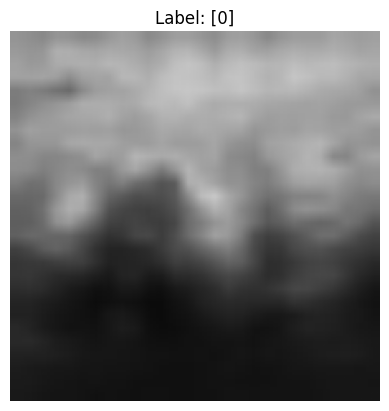

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single sample from the test dataset
sample_image, sample_label = test_dataset[10]  # Index 0, you can change this to visualize other images

# Convert the tensor image to a numpy array for visualization
# The image tensor shape is [C, H, W] so we need to permute it to [H, W, C] for visualization
sample_image_np = sample_image.permute(1, 2, 0).numpy()

# Normalize the image back to [0, 1] for proper visualization
sample_image_np = (sample_image_np * 0.5) + 0.5  # Reversing normalization: (x * std) + mean

# Plot the image
plt.imshow(sample_image_np)
plt.title(f"Label: {sample_label}")  # Display the label as title
plt.axis('off')  # Hide axis for better visualization
plt.show()
